In [1]:
import os
import datetime
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

import time
import glob
import tables as tb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce

2017-08-29 09:29:56


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

In [3]:
from invisible_cities.database import load_db

import invisible_cities.sierpe.blr as blr

import invisible_cities.reco.tbl_functions as tbl
import invisible_cities.reco.peak_functions as pf
import invisible_cities.reco.peak_functions_c as cpf

from   invisible_cities.evm.ic_containers           import S12Params 
from   invisible_cities.evm.ic_containers          import CalibVectors
from   invisible_cities.evm.ic_containers          import DeconvParams
from   invisible_cities.evm.ic_containers          import ThresholdParams

from   invisible_cities.core.system_of_units_c import units
from   invisible_cities.types.ic_types import minmax
from   invisible_cities.types.ic_types import Counter
import invisible_cities.icaro.signal_functions_mpl as mpl
from invisible_cities.icaro.pmaps_mpl import plot_s12
from invisible_cities.icaro.pmaps_mpl import plot_s2si_map
from invisible_cities.icaro.mpl_functions import draw_pmt_map

In [18]:
import invisible_cities.icaro.mpl_functions as mpl
import invisible_cities.icaro.signal_functions_mpl as sf

In [5]:
import invisible_cities.evm.event_model as evm

In [6]:
from invisible_cities.evm.pmaps import S12
from invisible_cities.evm.pmaps import S1
from invisible_cities.evm.pmaps import S2
from invisible_cities.evm.pmaps import S2Si
from invisible_cities.evm.pmaps import S1Pmt
from invisible_cities.evm.pmaps import S2Pmt

In [7]:
from invisible_cities.core.exceptions        import SipmEmptyList
from invisible_cities.core.exceptions        import SipmNotFound
from invisible_cities.core.exceptions        import PeakNotFound
from invisible_cities.core.exceptions        import InconsistentS12dPmtsd

In [8]:
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)

In [9]:
run_number = -4446
DataPMT = load_db.DataPMT(run_number)
DataSiPM = load_db.DataSiPM(run_number)
xs = DataSiPM.X.values
ys = DataSiPM.Y.values
pmt_active = np.nonzero(DataPMT.Active.values)[0].tolist()

In [10]:
channel_id = DataPMT.ChannelID.values
coeff_blr = abs(DataPMT.coeff_blr.values)
coeff_c = abs(DataPMT.coeff_c .values)
adc_to_pes = abs(DataPMT.adc_to_pes.values)
adc_to_pes_sipm = abs(DataSiPM.adc_to_pes.values)

In [ ]:
DataPMT

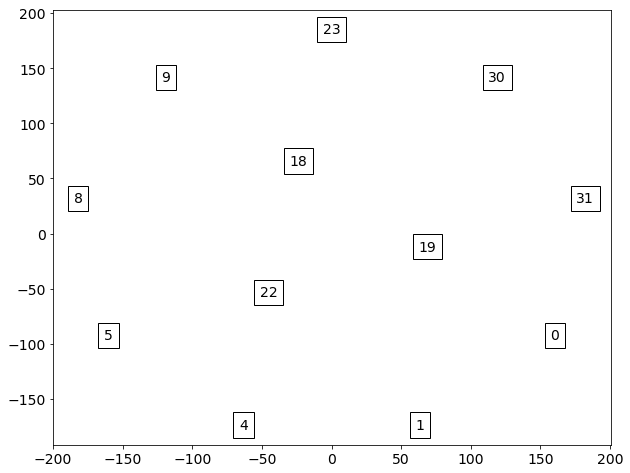

In [11]:
draw_pmt_map(-4446)

In [12]:
RWF_file = os.path.join(os.environ['IC_DATA'], 'MC_PreProd_July_2017',
                        'dst_NEXT_v1_00_05_Kr_ACTIVE_0_0_7bar_RWF_10.h5')
print('RWF file = {}'.format(RWF_file))

RWF file = /Users/jjgomezcadenas/Projects/ICDATA/MC_PreProd_July_2017/dst_NEXT_v1_00_05_Kr_ACTIVE_0_0_7bar_RWF_10.h5


In [13]:
h5rwf = tb.open_file(RWF_file,'r')

In [14]:
pmtrwf, pmtblr, sipmrwf = tbl.get_vectors(h5rwf)
NEVT, pmtrwf, sipmrwf, _ = tbl.get_rwf_vectors(h5rwf)
sp = tbl.get_sensor_params_from_vectors(pmtrwf, sipmrwf)
print(sp)

####################
SensorParams
####################
npmt: 12
pmtwl: 48000
nsipm: 1792
sipmwl: 1200



### Reconstruction Parameters

In [15]:
calib_vectors = CalibVectors(channel_id = DataPMT.ChannelID.values,
                             coeff_blr = abs(DataPMT.coeff_blr   .values),
                             coeff_c = abs(DataPMT.coeff_c   .values),
                             adc_to_pes = DataPMT.adc_to_pes.values,
                             adc_to_pes_sipm = DataSiPM.adc_to_pes.values,
                             pmt_active = np.nonzero(DataPMT.Active.values)[0].tolist())


deconv_params = DeconvParams(n_baseline = 45000,
                              thr_trigger = 5)

s1par = S12Params(time = minmax(min    = 99 * units.mus,
                           max    = 101 * units.mus),
                           stride = 4,
                           length = minmax(min = 6, max = 30),  #150 ns -- 500 ns
                           rebin_stride = 1)

s2par = S12Params(time = minmax(min    = 101 * units.mus,
                           max    = 1199 * units.mus),
                           stride = 40,
                           length = minmax(min = 120, max = 1e5),  # 4 mus --
                           rebin_stride=40)

thresholds = ThresholdParams(thr_s1=0.5 * units.pes,
                      thr_s2=1.0 * units.pes,
                      thr_MAU=3*units.adc,
                      thr_sipm=1.5*units.pes,
                      thr_SIPM=5*units.pes)



In [16]:
event = 0

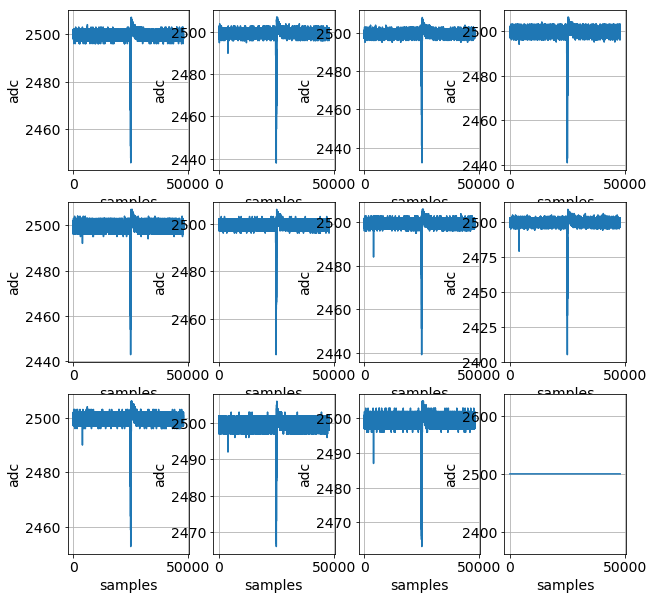

In [20]:
sf.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=1200, figsize=(10,10))

#### Deconvolution

In [21]:
CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr,
                         pmt_active  = pmt_active,
                         n_baseline  = deconv_params.n_baseline,
                         thr_trigger = deconv_params.thr_trigger)

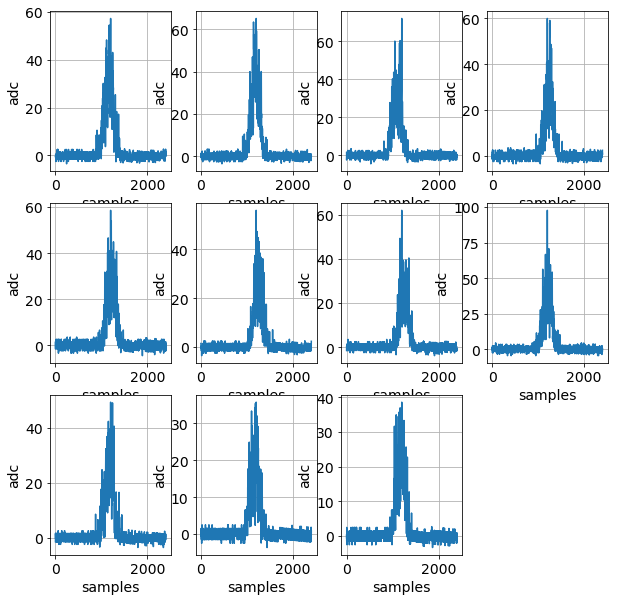

In [22]:
sf.plot_pmt_waveforms(CWF, zoom=True, window_size=1200, figsize=(10,10))

#### csum

In [23]:
csum, csum_mau = cpf.calibrated_pmt_sum(CWF,
                                            adc_to_pes,
                                            pmt_active  = pmt_active,
                                            n_MAU       = 100,
                                            thr_MAU     = thresholds.thr_MAU)

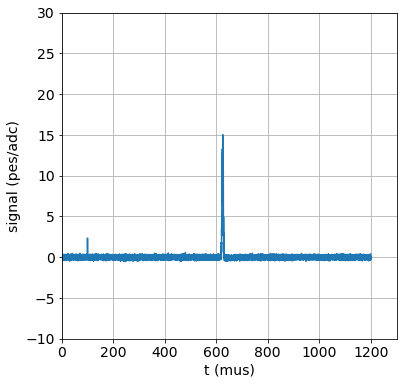

In [24]:
sf.plot_signal_vs_time_mus(csum,
                        t_min      = 0,
                        t_max      = 1300,
                        signal_min =    -10,
                        signal_max =  30,
                        figsize=(6,6))

#### S1 and S2

In [25]:
s2_ene, s2_indx = cpf.wfzs(csum, threshold=thresholds.thr_s2)
s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=thresholds.thr_s1)

In [26]:
s1 = cpf.find_s1(csum, s1_indx, **s1par._asdict())
s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())


In [27]:
s1

S1 (number of peaks = 1)
peak number = 0: Peak(samples = 14 width =      0.3 mus , energy =     17.5 pes
        height =      2.4 pes tmin-tmax = minmax(min=100.075, max=100.4) mus  

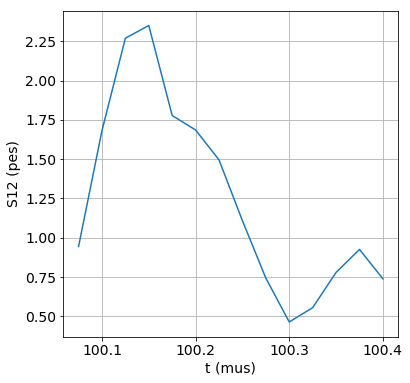

In [28]:
plot_s12(s1)

In [29]:
s2

S2 (number of peaks = 1)
peak number = 0: Peak(samples = 12 width =     10.7 mus , energy =   2775.5 pes
        height =    477.3 pes tmin-tmax = minmax(min=619.6750000000001, max=630.325) mus  

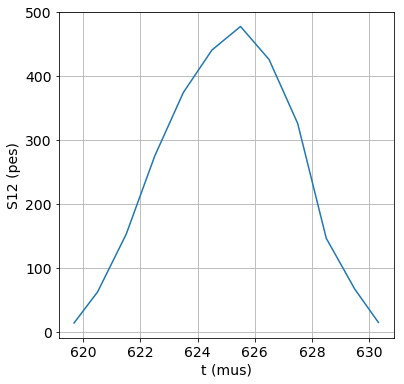

In [30]:
plot_s12(s2)

#### S2Si

In [31]:
sipmzs= cpf.signal_sipm(sipmrwf[event], adc_to_pes_sipm,
                           thr=thresholds.thr_sipm, n_MAU=100)

In [32]:
s2si = cpf.find_s2si(sipmzs, s2.s2d, thr = thresholds.thr_SIPM)

In [33]:
s2si

S2 (number of peaks = 1)
peak number = 0: Peak(samples = 12 width =     10.7 mus , energy =   2775.5 pes
        height =    477.3 pes tmin-tmax = minmax(min=619.6750000000001, max=630.325) mus  
--------------------------------------------------------------------------------
SiPMs for non-empty peaks

peak number = 0: nsipm in peak = (1510, 1516, 1517, 1518, 1519, 1524, 1525, 1526, 1527, 1533, 1534, 1535)
--------------------------------------------------------------------------------
SiPMs Waveforms

peak number = 0: sipm number = 1510
    sipm waveform (zs) = Peak(samples = 2 width =      1.0 mus , energy =      5.1 pes
        height =      2.8 pes tmin-tmax = minmax(min=624.5, max=625.5) mus 
peak number = 0: sipm number = 1516
    sipm waveform (zs) = Peak(samples = 2 width =      2.0 mus , energy =      5.9 pes
        height =      3.0 pes tmin-tmax = minmax(min=624.5, max=626.5) mus 
peak number = 0: sipm number = 1517
    sipm waveform (zs) = Peak(samples = 9 width =      7.8

In [34]:
s2si.number_of_peaks

1

In [35]:
s2si.sipms_in_peak(0)

(1510, 1516, 1517, 1518, 1519, 1524, 1525, 1526, 1527, 1533, 1534, 1535)

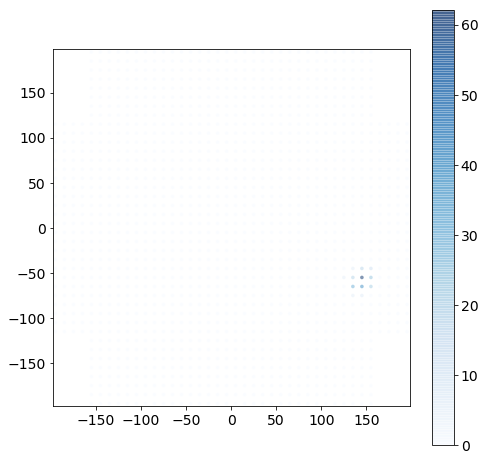

In [36]:
plot_s2si_map(s2si, run_number=-4446)

### S1 and S2 again, explicit way

In [37]:
s1_bounds = cpf.find_peaks(s1_indx, s1par.time, s1par.length, stride=s1par.stride)
s2_bounds = cpf.find_peaks(s2_indx, s2par.time, s2par.length, stride=s2par.stride)

In [38]:
s1_bounds

{0: <MemoryView of 'ndarray' at 0x10e28a1f0>}

In [39]:
s1 = S1(cpf.extract_peaks_from_waveform(csum, s1_bounds, rebin_stride=s1par.rebin_stride))
s2 = S2(cpf.extract_peaks_from_waveform(csum, s2_bounds, rebin_stride=s2par.rebin_stride))

In [40]:
s1

S1 (number of peaks = 1)
peak number = 0: Peak(samples = 14 width =      0.3 mus , energy =     17.5 pes
        height =      2.4 pes tmin-tmax = minmax(min=100.075, max=100.4) mus  

In [41]:
s2

S2 (number of peaks = 1)
peak number = 0: Peak(samples = 12 width =     10.7 mus , energy =   2775.5 pes
        height =    477.3 pes tmin-tmax = minmax(min=619.6750000000001, max=630.325) mus  

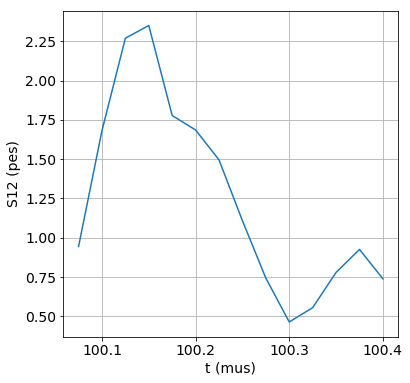

In [42]:
plot_s12(s1)

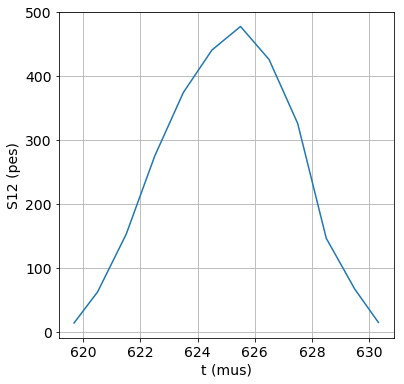

In [43]:
plot_s12(s2)

### s1pmt & s2pmt

In [44]:
s1pmtd = pf.get_s12pmtd(CWF, s1_bounds, rebin_stride=s1par.rebin_stride)

In [45]:
s2pmtd = pf.get_s12pmtd(CWF, s2_bounds, rebin_stride=s2par.rebin_stride)

In [46]:
for peak, s1_pmts in zip(s1.s1d.values(), s1pmtd.values()):
            print(peak[1], s1_pmts.sum(axis=0))

[ 0.94384777  1.68126873  2.26999651  2.3512243   1.77778049  1.68595749
  1.49557465  1.10830536  0.74288097  0.46375038  0.55486895  0.77922059
  0.92565381  0.73843629] [ 25.50113297  45.51970673  62.55931854  66.6085968   50.65042877
  45.68019867  38.71127319  29.73419952  19.74773407  12.74903488
  15.74995422  23.75710869  28.77124214  22.78854942]


In [ ]:
s1.s1d

In [47]:
for peak, s2_pmts in zip(s2.s2d.values(), s2pmtd.values()):
            print(peak[1], s2_pmts.sum(axis=0))

[  13.95495253   62.57440258  152.68751631  275.01128731  374.16026488
  440.48486599  477.31910774  425.64330842  325.81289027  146.34536985
   66.70245619   14.80677543] [   384.07879639   1710.81762695   4154.64111328   7439.140625
  10195.29199219  11995.34667969  12927.83886719  11529.67773438
   8836.54394531   3965.97558594   1780.86743164    398.82455444]


In [ ]:
try:
    s1pmt = S1Pmt(s1.s1d, pf.get_s12pmtd(CWF, s1_bounds, rebin_stride=s1par.rebin_stride))
    s2pmt = S2Pmt(s2.s2d, pf.get_s12pmtd(CWF, s2_bounds, rebin_stride=s2par.rebin_stride))
except InconsistentS12dPmtsd:
    print('Inconsistent')

In [ ]:
s1pmt

In [ ]:
for i, evt in enumerate(fevents):
            if events_recorded == irene.nmax + 1: continue
            print(i, evt)
            # Machinery in pmap_city.pmt_transformation, with access to CWF
            CWF     = irene.deconv_pmt(f.root.RD.pmtrwf[i])
            cCWF, _ = cpf.calibrated_pmt_mau(CWF, irene.adc_to_pes, irene.pmt_active, irene.n_MAU, irene.thr_MAU)

            csum, csum_mau  = irene.calibrated_pmt_sum(CWF)
            s1_ene, s1_indx = irene.csum_zs(csum_mau, threshold=irene.thr_csum_s1)
            s2_ene, s2_indx = irene.csum_zs(csum    , threshold=irene.thr_csum_s2)
            sipmzs = irene.calibrated_signal_sipm(f.root.RD.sipmrwf[evt])

            # Machinery in pmap_city.pmaps, with access to s2 peak bounds
            s1_bounds = cpf.find_peaks(s1_indx, irene.s1_params.time, 
                                                irene.s1_params.length, 
                                         stride=irene.s1_params.stride)

            s2_bounds = cpf.find_peaks(s2_indx,  irene.s2_params.time, 
                                                 irene.s2_params.length, 
                                          stride=irene.s2_params.stride)

            s1 = S1(cpf.extract_peaks_from_waveform(csum, s1_bounds, rebin_stride=irene.s1_params.rebin_stride))
            s2 = S2(cpf.extract_peaks_from_waveform(csum, s2_bounds, rebin_stride=irene.s2_params.rebin_stride))
            try:
                s1pmt = S1Pmt(s1.s1d, pf.get_s12pmtd(cCWF, s1_bounds, rebin_stride=irene.s1_params.rebin_stride))
                s2pmt = S2Pmt(s2.s2d, pf.get_s12pmtd(cCWF, s2_bounds, rebin_stride=irene.s2_params.rebin_stride))
            except InconsistentS12dPmtsd:
                print('*Discarded:', i, evt, 'inconsistent....'); continue

            s2si = cpf.find_s2si(sipmzs, s2.s2d, thr=irene.thr_sipm_s2)

            events_info = irene.get_run_and_event_info(f)
            event, timestamp = irene.event_and_timestamp(i, events_info)
            assert event==evt

            ipmt_writer(evt, s1, s2, s2si, s1pmt, s2pmt)
            run_ev_writer(irene.run_number, event, timestamp)
            if irene.run_number < 0: 
                mc_tracks = irene.get_mc_tracks(f)
                mc_writer(mc_tracks, event)

In [ ]:
event = 1
mpl.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=1200, figsize=(10,10))
CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr,
                         pmt_active  = pmt_active,
                         n_baseline  = deconv_params.n_baseline,
                         thr_trigger = deconv_params.thr_trigger)
csum, csum_mau = cpf.calibrated_pmt_sum(CWF,
                                            adc_to_pes,
                                            pmt_active  = pmt_active,
                                            n_MAU       = 100,
                                            thr_MAU     = thresholds.thr_MAU)
mpl.plot_signal_vs_time_mus(csum,
                        t_min      = 0,
                        t_max      = 1300,
                        signal_min =    -10,
                        signal_max =  30,
                        figsize=(6,6))
s2_ene, s2_indx = cpf.wfzs(csum, threshold=thresholds.thr_s2)
s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=thresholds.thr_s1)
s1 = cpf.find_s1(csum, s1_indx, **s1par._asdict())
s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())
print(s1)
print(s2)
plot_s12(s1)
plot_s12(s2)
sipmzs= cpf.signal_sipm(sipmrwf[event], adc_to_pes_sipm,
                           thr=thresholds.thr_sipm, n_MAU=100)
s2si = cpf.find_s2si(sipmzs, s2.s2d, thr = thresholds.thr_SIPM)
print(s2si)
print(s2si.number_of_peaks)
plot_s2si_map(s2si, run_number=-4446)

In [ ]:
event = 2
mpl.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=1200, figsize=(10,10))
CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr,
                         pmt_active  = pmt_active,
                         n_baseline  = deconv_params.n_baseline,
                         thr_trigger = deconv_params.thr_trigger)
csum, csum_mau = cpf.calibrated_pmt_sum(CWF,
                                            adc_to_pes,
                                            pmt_active  = pmt_active,
                                            n_MAU       = 100,
                                            thr_MAU     = thresholds.thr_MAU)
mpl.plot_signal_vs_time_mus(csum,
                        t_min      = 0,
                        t_max      = 1300,
                        signal_min =    -10,
                        signal_max =  30,
                        figsize=(6,6))
s2_ene, s2_indx = cpf.wfzs(csum, threshold=thresholds.thr_s2)
s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=thresholds.thr_s1)
s1 = cpf.find_s1(csum, s1_indx, **s1par._asdict())
s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())
print(s1)
print(s2)
plot_s12(s1)
plot_s12(s2)
sipmzs= cpf.signal_sipm(sipmrwf[event], adc_to_pes_sipm,
                           thr=thresholds.thr_sipm, n_MAU=100)
s2si = cpf.find_s2si(sipmzs, s2.s2d, thr = thresholds.thr_SIPM)
print(s2si)
print(s2si.number_of_peaks)
plot_s2si_map(s2si, run_number=-4446)

In [ ]:
event = 3
mpl.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=1200, figsize=(10,10))
CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr,
                         pmt_active  = pmt_active,
                         n_baseline  = deconv_params.n_baseline,
                         thr_trigger = deconv_params.thr_trigger)
csum, csum_mau = cpf.calibrated_pmt_sum(CWF,
                                            adc_to_pes,
                                            pmt_active  = pmt_active,
                                            n_MAU       = 100,
                                            thr_MAU     = thresholds.thr_MAU)
mpl.plot_signal_vs_time_mus(csum,
                        t_min      = 0,
                        t_max      = 1300,
                        signal_min =    -10,
                        signal_max =  30,
                        figsize=(6,6))
s2_ene, s2_indx = cpf.wfzs(csum, threshold=thresholds.thr_s2)
s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=thresholds.thr_s1)
s1 = cpf.find_s1(csum, s1_indx, **s1par._asdict())
s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())
print(s1)
print(s2)
plot_s12(s1)
plot_s12(s2)
sipmzs= cpf.signal_sipm(sipmrwf[event], adc_to_pes_sipm,
                           thr=thresholds.thr_sipm, n_MAU=100)
s2si = cpf.find_s2si(sipmzs, s2.s2d, thr = thresholds.thr_SIPM)
print(s2si)
print(s2si.number_of_peaks)
plot_s2si_map(s2si, run_number=-4446)

In [ ]:
event = 4
mpl.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=1200, figsize=(10,10))
CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr,
                         pmt_active  = pmt_active,
                         n_baseline  = deconv_params.n_baseline,
                         thr_trigger = deconv_params.thr_trigger)
csum, csum_mau = cpf.calibrated_pmt_sum(CWF,
                                            adc_to_pes,
                                            pmt_active  = pmt_active,
                                            n_MAU       = 100,
                                            thr_MAU     = thresholds.thr_MAU)
mpl.plot_signal_vs_time_mus(csum,
                        t_min      = 0,
                        t_max      = 1300,
                        signal_min =    -10,
                        signal_max =  30,
                        figsize=(6,6))
s2_ene, s2_indx = cpf.wfzs(csum, threshold=thresholds.thr_s2)
s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=thresholds.thr_s1)
s1 = cpf.find_s1(csum, s1_indx, **s1par._asdict())
s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())
print(s1)
print(s2)
plot_s12(s1)
plot_s12(s2)
sipmzs= cpf.signal_sipm(sipmrwf[event], adc_to_pes_sipm,
                           thr=thresholds.thr_sipm, n_MAU=100)
s2si = cpf.find_s2si(sipmzs, s2.s2d, thr = thresholds.thr_SIPM)
print(s2si)
print(s2si.number_of_peaks)
plot_s2si_map(s2si, run_number=-4446)

In [ ]:
event = 5
mpl.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=1200, figsize=(10,10))
CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr,
                         pmt_active  = pmt_active,
                         n_baseline  = deconv_params.n_baseline,
                         thr_trigger = deconv_params.thr_trigger)
csum, csum_mau = cpf.calibrated_pmt_sum(CWF,
                                            adc_to_pes,
                                            pmt_active  = pmt_active,
                                            n_MAU       = 100,
                                            thr_MAU     = thresholds.thr_MAU)
mpl.plot_signal_vs_time_mus(csum,
                        t_min      = 0,
                        t_max      = 1300,
                        signal_min =    -10,
                        signal_max =  30,
                        figsize=(6,6))
s2_ene, s2_indx = cpf.wfzs(csum, threshold=thresholds.thr_s2)
s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=thresholds.thr_s1)
s1 = cpf.find_s1(csum, s1_indx, **s1par._asdict())
s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())
print(s1)
print(s2)
plot_s12(s1)
plot_s12(s2)
sipmzs= cpf.signal_sipm(sipmrwf[event], adc_to_pes_sipm,
                           thr=thresholds.thr_sipm, n_MAU=100)
s2si = cpf.find_s2si(sipmzs, s2.s2d, thr = thresholds.thr_SIPM)
print(s2si)
print(s2si.number_of_peaks)
plot_s2si_map(s2si, run_number=-4446)